In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

daily_train = pd.read_csv('../Datasets\Daily-train.csv')
daily_test = pd.read_csv('../Datasets\Daily-test.csv')

__Selecting the Time Series Data for Our Predictions__

In [2]:
train = daily_train.transpose()
test = daily_test.transpose()

train = train[0]
train = train.iloc[1:]
train = train.dropna()

test = test[0]
test = test.iloc[1:]

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

new_index = pd.RangeIndex(start=len(train), stop=len(train) + len(test))
test.index = new_index

train = pd.DataFrame(train)
train = train[0]
train = train.drop(columns=[0])
train = train.apply(pd.to_numeric)

test = pd.DataFrame(test)
test = test[0]
test = test.drop(columns=[0])
test = test.apply(pd.to_numeric)

series = pd.concat([train, test], axis=1, keys=['Train', 'Test'])

**Holt Method with Linear Trend using the library Holt**

RMSE: 2.463191778158889


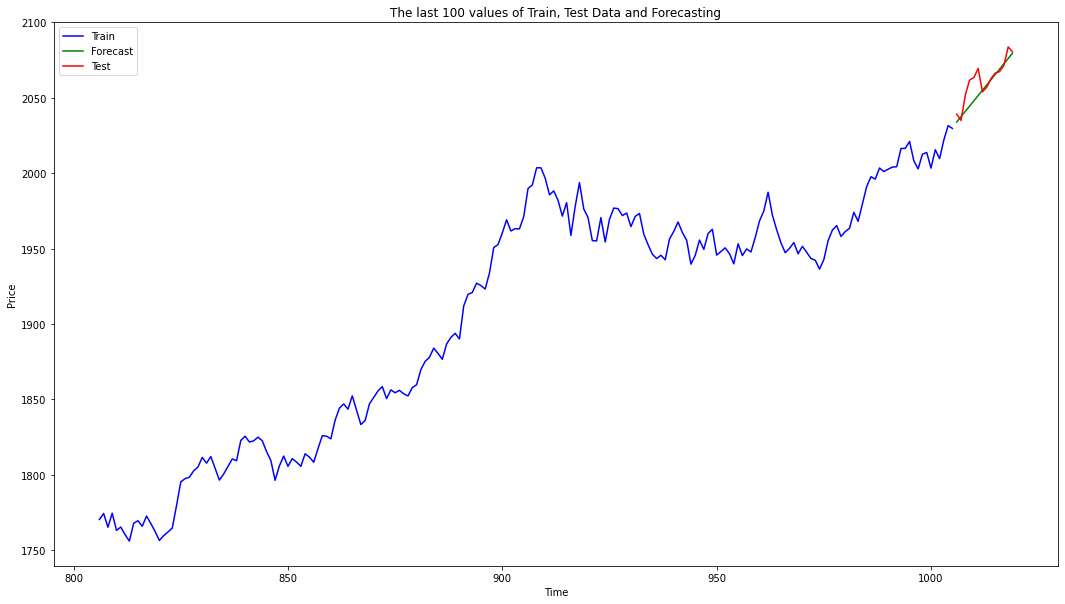

In [7]:
def Holt_with_linear_trend(train, test, alpha, beta, number_of_predicted_data):

    model = Holt(train).fit(alpha, beta, optimized=False)
    forecast = model.forecast(number_of_predicted_data)
    rmse = np.sqrt(mean_absolute_error(test, forecast.tail(len(test))))
    print(f'RMSE: {rmse}')

    fig, ax = plt.subplots(figsize=(18, 10))

    train.tail(200).dropna().plot(ax=ax, label='Train', color='blue', legend=True)
    forecast.tail(200).dropna().plot(ax=ax, label='Forecast', color='green', legend=True)
    test.dropna().plot(ax=ax, label='Test', color='red', legend=True)
    ax.set_title('The last 100 values of Train, Test Data and Forecasting')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    plt.show()

Holt_with_linear_trend(train, test, 0.7, 0.25, len(test))

**Holt's Trend (linear): Double Exponential Smoothing Implementation**<br><br>
**Mathematical Model**

![](Holts_linear_method.jpg)

## Explanation of the Mathematical Model

This mathematical model involves several functions and steps:

### Prediction Function
We use the prediction function to forecast the value at time (t+h), where h represents the number of time periods ahead we want to predict. The formula is:

𝑭𝒕+𝒉 = 𝑳𝒕 + h * 𝑻𝒕

- **𝑭𝒕+𝒉**: Represents the predicted value at time (t+h), h time periods ahead.
- **𝑳𝒕**: Denotes the current level value at time t.
- **𝑻𝒕**: Signifies the current trend value at time t.
- **h**: Indicates the number of periods ahead we wish to forecast.

### Level Function
The level function is used to estimate the level value at a specific time (t). The formula is:

𝑳𝒕 = α * 𝒀𝒕 + (1 – α) * (𝑳𝒕−𝟏 + 𝑻𝒕−𝟏)

- **𝒀𝒕**: Represents the actual value of the time series at time t.
- **𝒂**: Is a constant smoothing parameter for the level.
- **𝑳𝒕−𝟏**: Represents the previous level estimation at time t-1.
- **𝑻𝒕−𝟏**: Denotes the previous trend estimation at time t-1.

### Trend Function
The trend function is responsible for estimating the trend value at a specific time (t). The formula is:

𝑻𝒕 = β * (𝑳𝒕 + 𝑳𝒕−𝟏) + (1 – β) * 𝑻𝒕−𝟏

- **β**: Is a constant smoothing parameter for the trend.

To make predictions, we need to initialize the following:

1. **Initial Level (L) and Trend (T) Estimation**:<br>
   Initially, we need to estimate the starting values for the level (L) and trend (T) at the first time point (usually t=1). These initial estimates can be based on the first observation of the data, using an initial assessment, or other methods. Here, we choose to use the first observation:
   - 𝑳𝟏 = 𝒀𝟏
   - 𝜯𝟏 = 𝒀𝟐 - 𝒀𝟏 <br><br>

2. **Setting Smoothing Parameters (α and β)**:<br>
   We define two smoothing parameters, α for the level (L) and β for the trend (T). These parameters determine the weight given to level and trend observations in updating estimates for the next time step.

Once we have initialized the model with initial estimates and smoothing parameters, we can proceed to calculate level and trend estimates for future time periods and use these estimates to make forecasts for the future.

This mathematical model allows us to make predictions for future time points based on the level and trend estimates computed in previous steps.


In [8]:
""""
HOLT: Double Exponential Smoothing

Level Equation: L[t] = a * Y[t] + (1 - a) * (L[t-1] + T[t-1])
    L[t]: Level at time t
    Y[t]: Observed value at time t
    a: Smoothing parameter for level
    T[t-1]: Trend at time t-1

Trend Equation: T[t] = b * (L[t] - L[t-1]) + (1 - b) * T[t-1]
    T[t]: Trend at time t
    b: Smoothing parameter for trend

Forecast equation: F[t+h] = L[t] + h * T[t]
    F[t+h]: Forecasted value at time t+h
    h: Number of periods ahead to forecast

"""

def Holt_manual_with_linear_trend(train, test, alpha, beta, number_of_predicted_data):
    # Initialize lists for level, trend, and forecast values
    level = [0] * (len(train) + number_of_predicted_data)
    trend = [0] * (len(train) + number_of_predicted_data)
    Forecast = [0] * (len(train) + number_of_predicted_data)
    # Initialize level and trend with the first observed values
    level[1] = train.iloc[0]
    trend[1] = train.iloc[1] - train.iloc[0]

    # Perform Holt's Double Exponential Smoothing
    for t in range(2, len(train) + number_of_predicted_data):
        if t < len(train):
            # Calculate forecast within the training data range
            Forecast[t] = level[t-1] + trend[t-1]
            level[t] = alpha * train.iloc[t] + (1 - alpha) * (level[t-1] + trend[t-1])
            trend[t] = beta * (level[t] - level[t-1]) + (1 - beta) * trend[t-1]
        else:
            # Calculate forecast beyond the training data range
            Forecast[t] = level[t-1] + trend[t-1]
            level[t] = alpha * Forecast[t] + (1 - alpha) * (level[t-1] + trend[t-1])
            trend[t] = beta * (level[t] - level[t-1]) + (1 - beta) * trend[t-1]
            
    # Convert forecast, level, and trend lists to DataFrames
    Forecast = pd.DataFrame(Forecast)
    Forecast = Forecast.rename(columns={0: "Forecasting"})
    Level = pd.DataFrame(level)
    Level = Level.rename(columns={0: 'Level'})
    Trend = pd.DataFrame(level)
    Trend = Trend.rename(columns={0: 'Trend'})

    # Calculate RMSE to evaluate the forecast
    rmse = np.sqrt(mean_absolute_error(test, Forecast.tail(len(test))))
    print('Forecasting with Holt method and assuming a linear trend\n')
    print(f'Metrics to evaluate the Forecasting with a={alpha} and b={beta}')
    print(f'RMSE - manual: {rmse}\n')

    # Plot the last 200 values of the train, test, and forecast data
    fig, ax = plt.subplots(figsize=(18, 10))

    train.tail(200).dropna().plot(ax=ax, label='Train', color='blue', legend=True)
    Forecast.tail(200).dropna().plot(ax=ax, label='Forecast', color='green', legend=True)
    test.dropna().plot(ax=ax, label='Test', color='red', legend=True)
    ax.set_title('The last 200 values of Train, Test Data and Forecasting')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    plt.show()
    
    return Forecast, Level, Trend


__Visualizing and Evaluating the Holt's Method with α=0.7 and b=0.25 Using RMSE Metrics__

Forecasting with Holt method and assuming a linear trend

Metrics to evaluate the Forecasting with a=0.7 and b=0.25
RMSE - manual: 2.4631917781588957



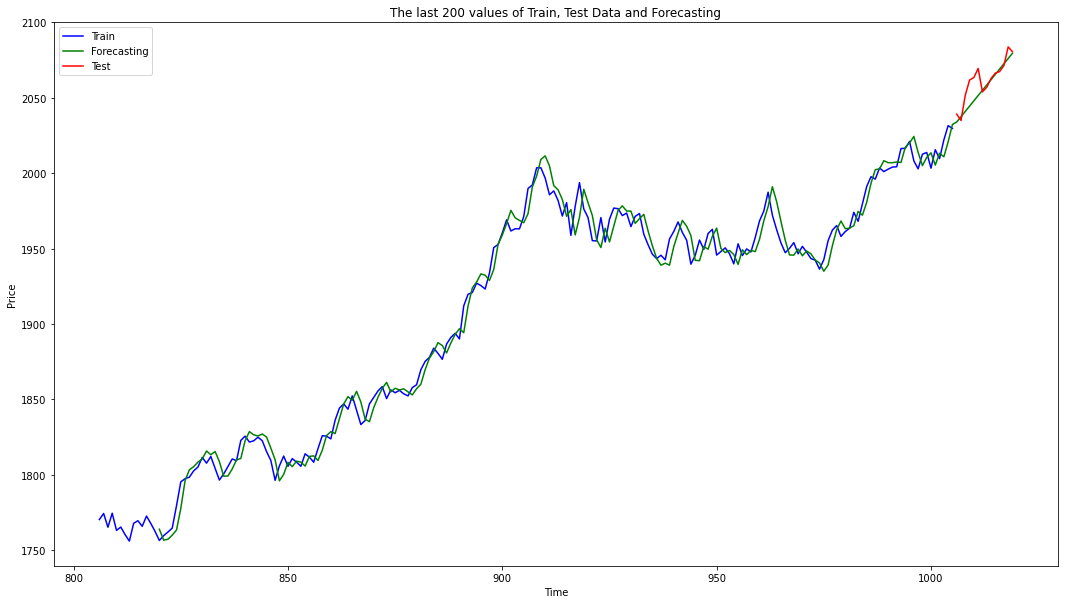

In [11]:
# Double Exponential Smoothing Holt's linear method with smoothing parameter for level (alpha) = 0.7 and smoothing parameter for trend (beta) = 0.25
Forecast, Level, Trend = Holt_manual_with_linear_trend(train, test, 0.7, 0.25, len(test))
# Keep a table with Forecasting, Level and Trend values
table = pd.concat([Level, Trend,Forecast, test], axis=1)
table = table.rename(columns={0 : 'Actual'})

__Presenting Tables Generated from Mathematical Model Outputs__

In [12]:
table

,Level,Trend,Forecasting,Actual
0,0.000000,0.000000,0.000000,NaN
1,1017.100000,1017.100000,0.000000,NaN
2,1017.690000,1017.690000,1019.300000,NaN
3,1019.286250,1019.286250,1019.487500,NaN
4,1019.400031,1019.400031,1021.033437,NaN
...,...,...,...,...
1015,2065.568448,2065.568448,2065.568448,2066.4
1016,2069.076193,2069.076193,2069.076193,2067.4
1017,2072.583939,2072.583939,2072.583939,2071.4
1018,2076.091684,2076.091684,2076.091684,2083.8


In [13]:
table.tail(14)

,Level,Trend,Forecasting,Actual
1006,2033.998738,2033.998738,2033.998738,2039.2
1007,2037.506483,2037.506483,2037.506483,2035.0
1008,2041.014229,2041.014229,2041.014229,2051.8
1009,2044.521975,2044.521975,2044.521975,2061.8
1010,2048.029720,2048.029720,2048.029720,2063.5
1011,2051.537466,2051.537466,2051.537466,2069.5
1012,2055.045211,2055.045211,2055.045211,2054.0
1013,2058.552957,2058.552957,2058.552957,2057.0
1014,2062.060702,2062.060702,2062.060702,2062.8
1015,2065.568448,2065.568448,2065.568448,2066.4


__Conlution:__<br><br>
**It's evident from both the graph and the RMSE (Root Mean Square Error) that Holt's model achieved significantly better predictions compared to the Simple Exponential Smoothing (SES) model. In fact, we can confidently say that Holt's predictions closely resemble the actual values, as indicated when we examine the values in the Forecasting and Actual columns from the tables.**